In [5]:
import scipy.signal as signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Import recorded raw data

In [6]:
# Load Row data into pandas
df = pd.read_csv("data/rawdata_2019-11-07T14:30:16.925Z.csv", names =['time', 'accX', 'accY', 'accZ', 'accuracy'])

## Data processing
Basically the same as Kotlin class 

In [7]:
# Make time starting from 0 and convert to ms
init_time = df.time[0]
df.time = (df.time - init_time)/10e6

# Calculate magnitude of acceleration vector
df['accM'] = np.sqrt(df.accX*df.accX + df.accY*df.accY + df.accZ*df.accZ) 

# Filter with moving average 
n = 70  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
df['filtered'] = signal.lfilter(b,a,df['accM'])

# Calculate average of last 2000 elements
n = 2000  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
df['running_avg'] = signal.lfilter(b,a,df['filtered'])

# Define limits
df['upperlimit'] = df['running_avg']*1.05
df['lowerlimit'] = df['running_avg']*0.95

# Detect when limits are crossed
rows_list = []
isBelow = False

for tuple in df.itertuples(): 
    if isBelow and tuple.filtered > tuple.upperlimit:
        isBelow = False
        rows_list.append({'time': tuple.time, 'value': tuple.filtered})
    
    if (not isBelow) and (tuple.filtered < tuple.lowerlimit) :
        isBelow = True

df2 = pd.DataFrame(rows_list)          

## Plot results for evaluation 

5523.7980247
7531.8897446


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


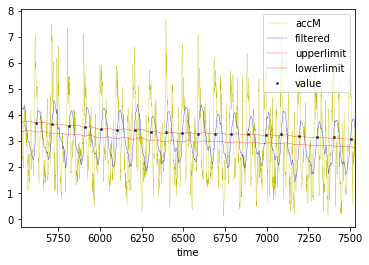

In [8]:
# Limit data to certain window
df = df.head(15000).tail(4000)
start = df.time.iloc[0]
end = df.time.iloc[-1]
df2 = df2[(start < df2['time']) & (df2['time'] < end)] 

ax = df.plot(x = 'time', y=['accM', 'filtered', 'upperlimit', 'lowerlimit'], color ='ybrr', kind = 'line', linewidth=0.3)

df2.plot(x='time', y='value', linestyle='None', marker='x', color='k', markersize=2, ax=ax)
plt.savefig('detection.eps', format='eps')